### CO2 preprocess

In [6]:
import pandas as pd
from pyparsing import *
import numpy as np
import sklearn.preprocessing
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model

def load_data():
    
    N = 721
    df=pd.read_csv('Mauna_Loa_CO2.csv', sep=',')
    
    data = np.zeros(shape=(N, 2))
    mod_name = Word(nums)
    mod_dots = Word(nums + '.' + '-')
    parse_module = mod_name + mod_name + mod_dots + mod_dots + mod_dots

    for i in range(df.shape[0]):
        b = parse_module.parseString(df.values[i][0])
        data[i, 0] = np.float(b[4])
        data[i, 1] = np.float(b[2])
    
    return data


def preproc(data):
    def inv_preproc(x, y):
        data = np.array([y,x]).T
        data = scaler.inverse_transform(data)
        x = data[:,1]
        y = data[:,0]
        y_trend = regr.predict(x[:,np.newaxis])
        y  = y + y_trend
        return x, y
    
    data = data.copy()
    train = data[:500, :]
    test = data[500:, :]
    
    x_train = train[:, 1]
    y_train = train[:, 0]
    x_test = test[:, 1]
    y_test = test[:, 0]
    
    regr = linear_model.LinearRegression()
    regr.fit(x_train[:,np.newaxis], y_train)
    
    y_train_trend = regr.predict(x_train[:,np.newaxis])
    y_train  = y_train - y_train_trend
    
    y_test_trend = regr.predict(x_test[:,np.newaxis])
    y_test  = y_test - y_test_trend

    
    train[:,0] = y_train
    test[:,0] = y_test
    
    scaler = sklearn.preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler.fit(train)

    train = scaler.transform(train)
    test = scaler.transform(test)
    
    x_train = train[:, 1]
    y_train = train[:, 0]
    x_test = test[:, 1]
    y_test = test[:, 0]
    
    return (x_train, y_train, x_test, y_test),inv_preproc

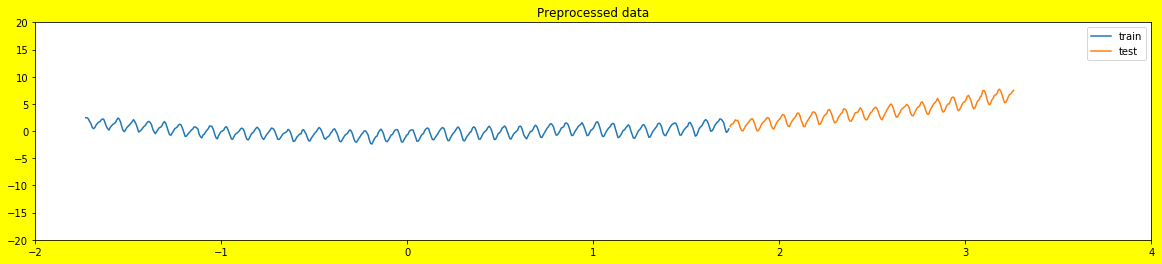

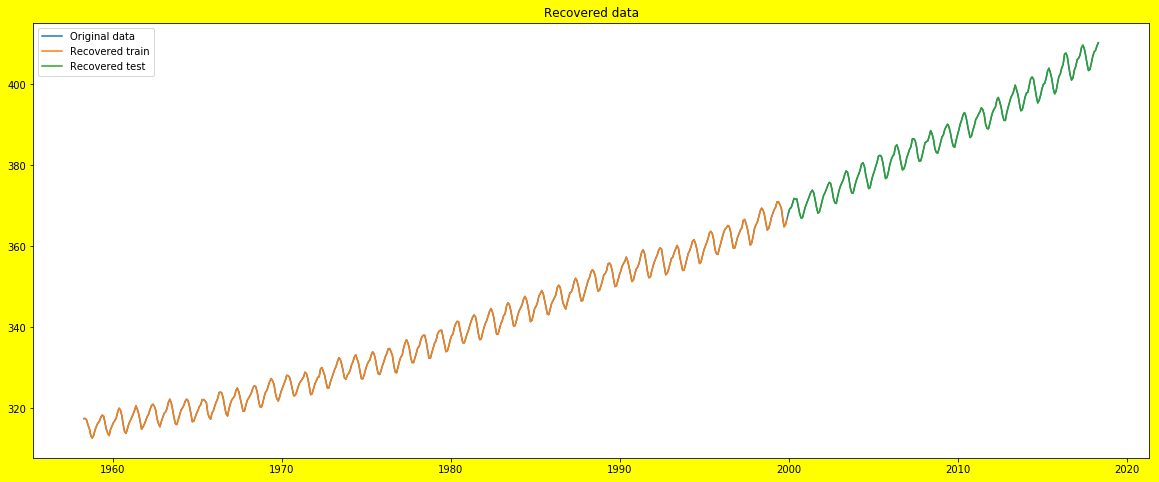

In [7]:
data = load_data()

(x_train, y_train, x_test, y_test),inv_preproc = preproc(data)



# =============================== plot ===============================


plt.figure(figsize=(20, 4), facecolor='yellow')
plt.title('Preprocessed data')
plt.plot(x_train, y_train, label='train')
plt.axis([-2, 4, -20, 20])
plt.plot(x_test, y_test, label='test')
plt.legend(loc='best')
plt.show()

recover_x_train, recover_y_train = inv_preproc(x_train, y_train)
recover_x_test, recover_y_test = inv_preproc(x_test, y_test)




# ================================= plot ==================================



plt.figure(figsize=(20, 8), facecolor='yellow')
plt.title('Recovered data')
plt.plot(data[:, 1], data[:, 0], label='Original data')
plt.plot(recover_x_train, recover_y_train, label='Recovered train')
plt.plot(recover_x_test, recover_y_test, label='Recovered test')

plt.legend()
plt.show()

### Solar Irradiance preprocess

In [4]:
import pandas as pd
from pyparsing import *
import numpy as np
import sklearn.preprocessing
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model

def load_data():
    N=391
    df=pd.read_csv('Sol_Irrad.txt', sep=',')

    data = np.zeros(shape=(N, 2))
    mod_name = Word(nums)
    mod_dots = Word(nums + '.')
    parse_module = mod_dots + mod_dots + mod_dots

    for i in range(df.shape[0]):
        b = parse_module.parseString(df.values[i][0])
        data[i, 0] = np.float(b[2])
        data[i, 1] = np.float(b[0])
    
    return data

def preproc(data):
    def inv_preproc(x, y):
        data = np.array([y, x]).T
        data = scaler.inverse_transform(data)
        x = data[:, 1]
        y = data[:, 0]
        return x, y
    
    data = data.copy()
    
    train_data = np.asarray(data[:15, :].tolist() + data[35:95, :].tolist() + data[115:175, :].tolist() \
                          + data[195:255, :].tolist() + data[275:335, :].tolist() + data[355:, :].tolist())
    test_data  = np.asarray(data[15:35, :].tolist() + data[95:115, :].tolist() + data[175:195, :].tolist() \
                          + data[255:275, :].tolist() + data[335:355, :].tolist())
    
    
    scaler = sklearn.preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler.fit(train_data)
    
    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)
    
    x_train = train_data[:, 1]
    y_train = train_data[:, 0]
    x_test = test_data[:, 1]
    y_test = test_data[:, 0]
    
    return (x_train, y_train, x_test, y_test), inv_preproc

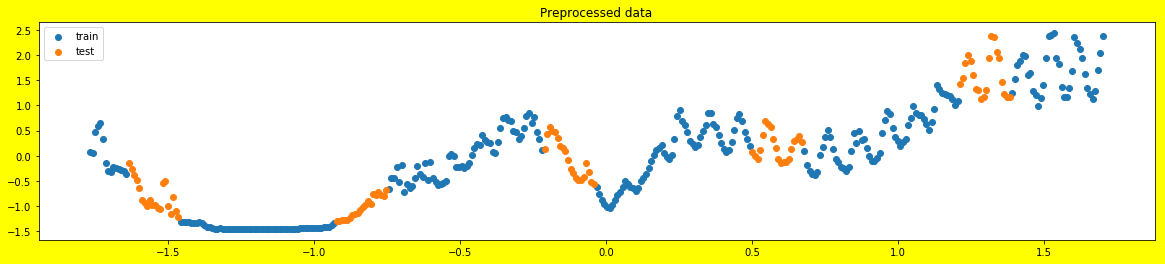

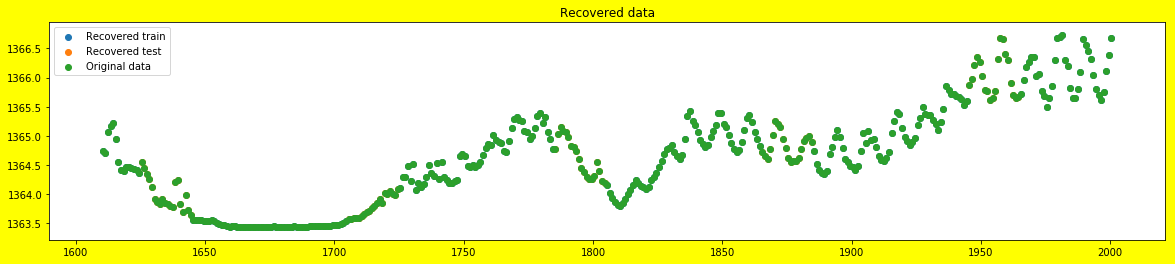

In [6]:
data = load_data()

(x_train, y_train, x_test, y_test), inv_preproc = preproc(data)


# =============================== plot ===============================


plt.figure(figsize=(20, 4), facecolor='yellow')
plt.title('Preprocessed data')
plt.scatter(x_train, y_train, label='train')
# plt.axis([-2, 4, -2, 4])
plt.scatter(x_test, y_test, label='test')
plt.legend(loc='best')
plt.show()

recover_x_train, recover_y_train = inv_preproc(x_train, y_train)
recover_x_test, recover_y_test = inv_preproc(x_test, y_test)

# ================================= plot ==================================

plt.figure(figsize=(20, 4), facecolor='yellow')
plt.title('Recovered data')
plt.scatter(recover_x_train, recover_y_train, label='Recovered train')
plt.scatter(recover_x_test, recover_y_test, label='Recovered test')
plt.scatter(data[:, 1], data[:, 0], label='Original data')
plt.legend()
plt.show()

### FeedForvardNet

In [2]:
import torch,torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

def get_linear_network(layers_num,nonlinearity,dropout = 0,device = torch.device("cpu")):
    if layers_num<2:
        raise Excaption("Use more layers")
    start_layers = [nn.Linear(1,1024),nn.Dropout(dropout),nonlinearity]
    inter_layers = []
    if layers_num>=3:
        inter_layers = [nn.Linear(1024,1024),nn.Dropout(dropout),nonlinearity]
    end_layers = [nn.Linear(1024,1)]
    layers = start_layers+inter_layers+end_layers
    linear_network = nn.Sequential(*layers)
    return linear_network.to(device)

def train_linear_network(network,X,Y,num_iters = 1e6,threshold = 1e-3,device = torch.device("cpu")):
    network.train()
    X = Variable(torch.FloatTensor(X)).unsqueeze(1).to(device)
    Y = Variable(torch.FloatTensor(Y)).unsqueeze(1).to(device)
    opt = torch.optim.SGD(network.parameters(),lr = 0.01,weight_decay=1e-6,momentum=0.9)
    MSELoss = nn.modules.loss.MSELoss()
    history = []
    for iter in range(num_iters):
        Y_pred = network(X)
        loss = MSELoss(Y_pred,Y)
        history.append(loss.data.cpu().numpy())
        if iter > 0 and history[-1] - history[-2]>threshold:
            break
        opt.zero_grad()
        loss.backward()
        opt.step()
    network.eval()
    return network,history




In [17]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
network = get_linear_network(3,nn.ReLU(),dropout = 0.2,device  = device)
network,history = train_linear_network(network,x_train,y_train,100000,threshold = 1,device = device)
torch.save(network,'linear_relu_network.p')
network = torch.load('linear_relu_network.p')

In [19]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
network = get_linear_network(3,nn.Tanh(),dropout = 0.2,device  = device)
network,history = train_linear_network(network,x_train,y_train,100000,threshold = 1,device = device)
torch.save(network,'linear_tanh_network.p')
network = torch.load('linear_tanh_network.p')

In [12]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
network = get_linear_network(3,nn.ReLU(),dropout = 0.2,device  = device)
network,history = train_linear_network(network,x_train,y_train,100000,threshold = 1,device = device)
torch.save(network,'solarirrad_linear_relu_network.p')
network = torch.load('solarirrad_linear_relu_network.p')

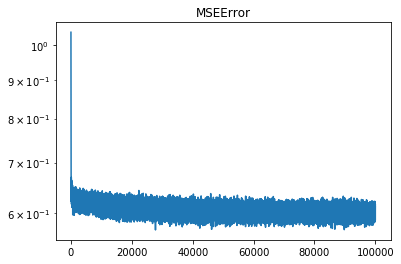

In [20]:
import matplotlib.pyplot as plt
plt.title("MSEError")
plt.semilogy(history)
plt.show()

### LeNet

In [45]:
import torch,torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

from torchvision.datasets import MNIST
import torchvision.transforms as transforms

class Flatten(nn.Module):
    def forward(self,x):
        return x.view(x.size(0),-1)
    
class Empty(nn.Module):
    def forward(self,x):
        return x
    
def get_convnet(nonlinearity,dropout = 0,device = torch.device("cpu")):
    convnet = nn.Sequential(nn.Conv2d(1,6,5),
                            nonlinearity,
                            nn.MaxPool2d(2),
                            nn.Conv2d(6,16,5),
                            nonlinearity,
                            nn.MaxPool2d(2),
                            Flatten(),
                            nn.Linear(400,120),
                            nonlinearity,
                            nn.Linear(120,84),
                            nonlinearity,
                            nn.Dropout(dropout),
                            nn.Linear(84,10))
    return convnet.to(device)

def train_convnet(network,X,Y,num_iters = 1e6,threshold = 1e-3,device = torch.device("cpu")):
    network.train()
    X = Variable(torch.FloatTensor(X)).to(device)
    Y = Variable(torch.LongTensor(Y)).to(device)
    opt = torch.optim.SGD(network.parameters(),lr = 0.01,weight_decay=1e-4,momentum=0.9)
    NLLLoss = nn.modules.loss.NLLLoss()
    history = []
    for iter in range(num_iters):
        Y_logp = F.log_softmax(network(X),dim = -1)
        loss = NLLLoss(Y_logp,Y)
        history.append(loss.data.cpu().numpy())
        if iter > 0 and history[-1] - history[-2]>threshold:
            break
        opt.zero_grad()
        loss.backward()
        opt.step()
    network.eval()
    return network,history



def get_minst_data():
    trans = transforms.Compose([transforms.Pad(2),transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    mnist = MNIST('MNIST',download=True,transform=trans)

    data_loader = torch.utils.data.DataLoader(mnist,
                                              batch_size=60000,
                                              shuffle=True)
    imags, labels = data_loader.__iter__().__next__()
    return imags, labels

In [100]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
imags, labels = get_minst_data()
num_iters = 100
convnet = get_convnet(Empty(),dropout = 0.5,device=device)
convnet,history = train_convnet(convnet,imags,labels,num_iters,device=device,threshold=1)
# torch.save(convnet,'convnet.p')
# convnet = torch.load('convnet.p')

In [30]:
history

[array(2.3036683, dtype=float32), array(2.303918, dtype=float32)]

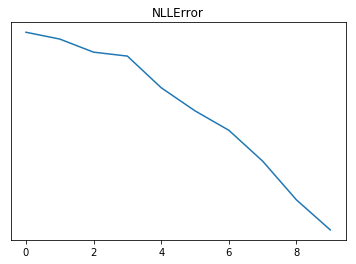

In [44]:
import matplotlib.pyplot as plt
plt.title("NLLError")
plt.semilogy(history)
plt.show()

### Uncertainty Estimation

In [7]:
def get_test_train_minst_data(test_part = 0.1):
    trans = transforms.Compose([transforms.Pad(2),transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    mnist = MNIST('MNIST',download=True,transform=trans)

    data_loader = torch.utils.data.DataLoader(mnist,
                                              batch_size=60000,
                                              shuffle=True)
    imags, labels = data_loader.__iter__().__next__()
    imags_train, labels_train = imags[int(60000*test_part):],labels[int(60000*test_part):]
    imags_test, labels_test = imags[:int(60000*test_part)],labels[:int(60000*test_part)]
    return imags_train, labels_train, imags_test, labels_test


In [311]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
imags_train, labels_train, imags_test, labels_test = get_test_train_minst_data()
num_iters = 10
convnet = get_convnet(Empty(),dropout = 0.5,device=device)
convnet,history = train_convnet(convnet,imags_train,labels_train,num_iters,device=device,threshold=1)
# torch.save(convnet,'uncert_convnet.p')
# convnet = torch.load('uncert_convnet.p')

In [320]:
convnet = torch.load('uncert_convnet.p')

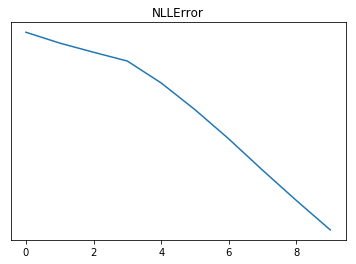

In [312]:
import matplotlib.pyplot as plt
plt.title("NLLError")
plt.semilogy(history)
plt.show()

In [321]:
output = convnet(imags_test.to(device))
probs = F.softmax(output,dim = -1).cpu().data.numpy()
pred_labels = np.argmax(probs,axis = -1)
is_right_prediction = (pred_labels == labels_test.data.numpy())
label_probs = probs[np.arange(len(probs)),pred_labels]



In [322]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

def check_metrics(label_probs,is_right_prediction):
    fpr, tpr, _ = roc_curve(is_right_prediction,label_probs)
    roc_auc = auc(fpr, tpr)
    baseline = 0.5
    plt.title("ROC curve. ROCAUC = "+str(roc_auc)[:4]+"/"+str(baseline))
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr)
    plt.show()

    precision, recall, _ = precision_recall_curve(is_right_prediction,label_probs,pos_label=1)
    sorted_inds = np.argsort(recall)
    precision, recall = precision[sorted_inds], recall[sorted_inds]
    pr_auc = auc(recall,precision)
    P = (is_right_prediction==1).sum()
    N = (is_right_prediction==0).sum()
    baseline = P/(P+N)
    plt.title("PR curve (success). PRAUC = "+str(pr_auc)[:4]+"/"+str(baseline)[:4])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.plot(recall,precision)
    plt.show()

    precision, recall, _ = precision_recall_curve(is_right_prediction,(1-label_probs),pos_label=0)
    sorted_inds = np.argsort(recall)
    precision, recall = precision[sorted_inds], recall[sorted_inds]
    pr_auc = auc(recall,precision)
    baseline = N/(P+N)
    plt.title("PR curve (error). PRAUC = "+str(pr_auc)[:4]+"/"+str(baseline)[:4])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.plot(recall,precision)
    plt.show()

Simple SoftMax


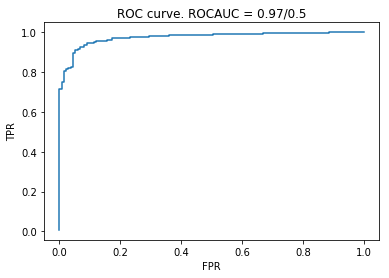

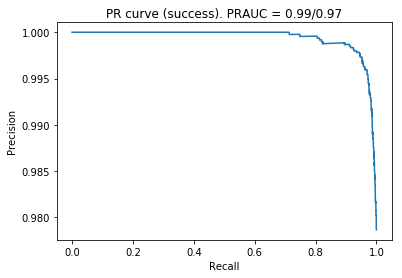

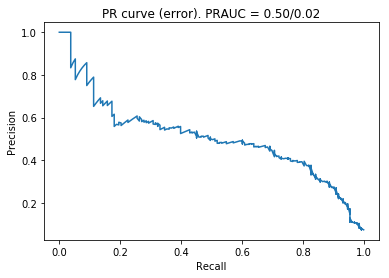

In [323]:
print("Simple SoftMax")
check_metrics(label_probs,is_right_prediction)

In [316]:
def get_dropout_probs(network,test_data,num_sampls = 1000):
    network.train()
    probs = []
    with torch.no_grad():
        for i in range(num_sampls):
            output = network(test_data)
            prob = F.softmax(output,dim = -1)
            probs.append(prob.unsqueeze(-1))
        probs = torch.cat(probs,dim = -1)
        probs_mean = probs.mean(dim = -1)
        prob_var = probs.var(dim = -1)
        
        pred_labels = torch.argmax(probs_mean,dim = -1)
        crit_probs = []
        for i in range(num_sampls):
            output = network(test_data)
            prob = F.softmax(output,dim = -1)
            is_grate = (prob > prob[np.arange(len(probs_mean)),pred_labels].unsqueeze(-1).repeat((1,10))).sum(dim = -1)>=1
            crit_probs.append(is_grate.unsqueeze(-1))
        crit_probs = torch.cat(crit_probs,dim = -1)
        crit_probs = crit_probs.float().mean(dim = -1)
            
    return probs_mean,prob_var,1-crit_probs

from scipy.stats import multivariate_normal,norm
def criterion(probs_mean,prob_var):
    prob_std = np.sqrt(prob_var)*1e10
    cs = []
    for i in range(len(probs_mean)):
        arg_max = np.argmax(probs_mean[i])
        c = multivariate_normal(mean=probs_mean[i],cov = np.diag(prob_std[i]),allow_singular= True).pdf(1/len(probs_mean))
        cs.append(c)
    return np.array(cs)


In [324]:
import gc
torch.cuda.empty_cache()
gc.collect() 

# device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
probs_mean,prob_var, crit_probs = get_dropout_probs(convnet.to(device),imags_test.to(device),10000)
probs_mean,prob_var, crit_probs = probs_mean.cpu().data.numpy(),prob_var.cpu().data.numpy(), crit_probs.cpu().data.numpy()
pred_labels = np.argmax(probs_mean,axis = -1)
is_right_prediction = (pred_labels == labels_test.data.numpy())
# label_probs = prob_var[np.arange(len(probs_mean)),pred_labels]
label_probs = criterion(probs_mean,prob_var)

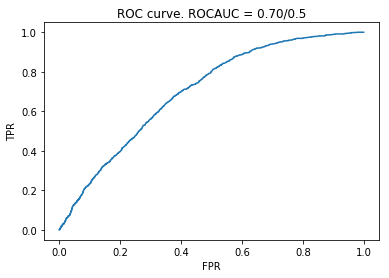

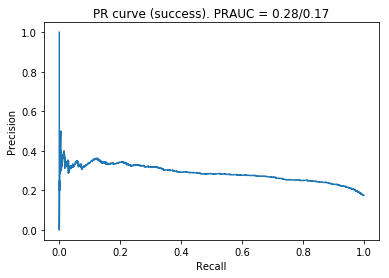

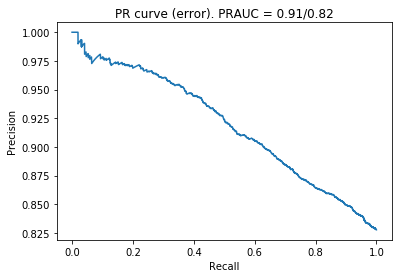

In [319]:
label_probs = probs_mean[np.arange(len(probs_mean)),pred_labels]


check_metrics(crit_probs,is_right_prediction)

In [ ]:
def get_mean_var_classification(network,test_data,num_sampls = 1000):
    network.train()
    probs = []
    with torch.no_grad():
        for i in range(num_sampls):
            output = network(test_data)
            prob = F.softmax(output,dim = -1)
            probs.append(prob.unsqueeze(-1))
        probs = torch.cat(probs,dim = -1)
        probs_mean = probs.mean(dim = -1)
        prob_var = probs.var(dim = -1)
            
    return probs_mean.data.numpy(),prob_var.data.numpy()

def get_mean_var_regression(network,test_data,num_sampls = 1000):
    network.train()
    ys = []
    with torch.no_grad():
        for i in range(num_sampls):
            output = network(test_data)
            y.append(y.unsqueeze(-1))
        ys = torch.cat(ys,dim = -1)
        y_mean = ys.mean(dim = -1)
        y_var = ys.var(dim = -1)
            
    return y_mean.data.numpy(),y_var.data.numpy()


device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
convnet = torch.load('convnet.p')
probs_mean,prob_var = get_mean_var(convnet.to(device),imags_test.to(device),num_sampls = 1000)